# Test Statistic for Random Forest Independence Test
In this notebook, we will work on generating a test statistic using our random forest estimate of conditional entropy. Our test is setup as so:  

Given $(Y, X)$, where $Y$ is binary.  
$H_0$: $X$ is independent from $Y$  
$H_a$: $X$ is dependent on $Y$  

This can be translated to:  
$H_0$: $MI(X, Y) = 0$  
$H_a$: $MI(X, Y) \neq 0$  

There are two methods we explore in this notebook:
1. Compute the cdf of H(Y) evaluated at H(Y|X; under alternative)
2. Permutation test

## 1. Compute the cdf of H(Y) evaluated at H(Y|X; under alternative)

#### Reasoning behind this:
MI_0(X,Y) - MI_A(X,Y; under alt) = H(Y|X; under alt) -H(Y|X; under null)  

#### Math
Initial results: cannot do this because $H(\cdot)$ is not invertible function

Consider $Y_1, \dots, Y_n$. $Y_i \sim Bernoulli(p)$

$H(Y) = H(p) = -plog(p) - (1 - p)log(1 - p)$  
$\widehat{H(Y)} = H(\hat{p}) = -\hat{p}log\hat{p} - (1 - \hat{p})log(1 - \hat{p})$ where $\hat{p} = \frac{\sum{Y_i}} {n}$  
Note that $\hat{p}$ is just sum of independent bernoulli's so binomial. However, to compute distribution of $H(\hat p )$, we need to perform a density transformation on $\hat{p}$ using a non-invertible function (Shannon's entropy is non-invertible$. 

## 2. Permutation test
Under the null, $X$ and $Y$ are independent. This means you should be able to permute around the Y labels and still get the same mutual information / coditional entropy. So, for the permtuation test, we will do exactly this:  

1. Permute the Y labels
2. Calculate Mutual information
3. Repeat 1000 times
4. How many times out of total trials did we get mutual information = 0?

We will focus on the same example as the previous notebooks.
Consider $(X, Y)$. Let $Y \sim Bernoulli(1/2)$ ($Y$ = -1 or 1) and $X \sim \mathcal N(y\mu, 1)$  

Note, we are focusing on one dimensional case for now.

### Sampling Code

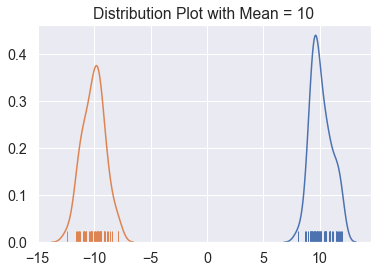

In [3]:
import numpy as np

# NOTE: we are storing y's as 1's or 0's but still doing the mean stuff correctly
def get_sample(n, mean, var):
    x_sample = []
    y_sample = []
    for i in range(n):
        y = np.random.binomial(1, .5)
        if (y == 0):
            x = np.random.normal(-mean, var)
        else:
            x = np.random.normal(mean, var)
        x_sample.append(x)
        y_sample.append(y)
    return x_sample, y_sample

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.3)

def split_by_class(sample):
    y_one = [pair for pair in sample if pair[1] == 1]
    y_neg_one = [pair for pair in sample if pair[1] == 0]
    return y_one, y_neg_one

X, y = get_sample(100, 10, 1)
sample = list(zip(X, y))
class_one, class_neg_one = split_by_class(sample)
sns.distplot(list(zip(*class_one))[0], hist=False, rug=True)
sns.distplot(list(zip(*class_neg_one))[0], hist=False, rug=True)
plt.title("Distribution Plot with Mean = 10")
plt.show()

### Algorithm Code

In [28]:
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

X, y = get_sample(1000, 1, 1)
X = np.array(X).reshape(-1, 1)

def rf_entropy_estimate_bagging(X, y, n_estimators = 200, max_samples = .63, bootstrap = True, depth = 4):
    model = BaggingClassifier(DecisionTreeClassifier(max_depth = depth), 
                              n_estimators = n_estimators, 
                              max_samples= max_samples, 
                              bootstrap = bootstrap)
    model.fit(X, y)
    class_counts = np.zeros((X.shape[0], model.n_classes_))
    for tree in model:
        # get out of bag indicies
        unsampled_indices = _generate_unsampled_indices(tree.random_state, len(X))
        # get all node counts
        node_counts = tree.tree_.n_node_samples
        # get counts for out of bag samples
        partition_counts = np.asarray([node_counts[x] for x in tree.apply(X[unsampled_indices])])
        # get probability for out of bag samples
        class_probs = tree.predict_proba(X[unsampled_indices])
        # find total elements for out of bag samples
        elems = np.multiply(class_probs, partition_counts[:, np.newaxis])
        # store counts for each x (repeat fhis for each tree)
        class_counts[unsampled_indices] += elems
    # calculate p(y|X = x) for all x's
    probs = class_counts/class_counts.sum(axis = 1, keepdims = True)
    entropies = -np.sum(np.log(probs)*probs, axis = 1)
    # convert nan to 0
    entropies = np.nan_to_num(entropies)
    return np.mean(entropies)

np.warnings.filterwarnings('ignore')

rf_entropy_estimate_bagging(X, y, 500, .63)


0.38004011331880944

### Calculate Mutual Information

In [ ]:
from scipy.stats import entropy

def get_entropy(X):
    probs = np.bincount(X)/len(X)
    return entropy(probs)

def get_mutual_information(X, y, n_estimators = 200, max_samples = .63, bootstrap = True, depth = 4):
    cond_entropy = rf_entropy_estimate_bagging(X, y, n_estimators, max_samples, bootstrap, depth)
    h_y = get_entropy(y)
    return h_y - cond_entropy

In [16]:
### TESTS ###
print("Mean:", 0)
X, y = get_sample(1000, 0, 1)
X = np.array(X).reshape(-1, 1)
print("MI", get_mutual_information(X, y))

print("Mean:", 1)
X, y = get_sample(1000, 1, 1)
X = np.array(X).reshape(-1, 1)
print("MI", get_mutual_information(X, y))

print("Mean:", 5)
X, y = get_sample(1000, 5, 1)
X = np.array(X).reshape(-1, 1)
print("MI", get_mutual_information(X, y))

Mean: 0
MI 0.0024550923351904785
Mean: 1
MI 0.36451549198254557
Mean: 5
MI 0.6931151802186033


### Permutation Test
For now, we will just return a list of mutual information values.

In [29]:
from random import shuffle
from tqdm import tqdm
def permutation_test(mean, n = 1000, trials = 1000):
    mutual_infos = []
    X, y = get_sample(n, mean, 1)
    X = np.array(X).reshape(-1, 1)
    print(X)
    for _ in tqdm(range(trials)):
        shuffle(y)
        mutual_infos.append(get_mutual_information(X, y))
    return mutual_infos

In [24]:
mutual_informations = permutation_test(0)
print("Mean", 0)
print(mutual_informations[: 5])

100%|██████████| 1000/1000 [06:07<00:00,  1.96it/s]

Mean 0
[0.00013177530814567628, 0.00043726619558381863, 0.00018917934655637847, 0.002741598352936525, 0.001509696938680638]


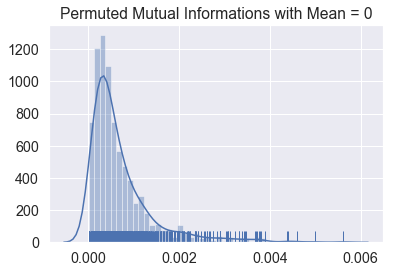

In [25]:
sns.distplot(mutual_informations, hist=True, rug=True)
plt.title("Permuted Mutual Informations with Mean = 0")
plt.show()

In [31]:
mutual_informations = permutation_test(10)
sns.distplot(mutual_informations, hist=True, rug=True)
plt.title("Permuted Mutual Informations with Mean = 1")
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

[[ -8.96205071]
 [ 10.30418471]
 [  9.62099326]
 [  9.81963278]
 [ 10.87501587]
 [ -8.87728447]
 [ 10.75036431]
 [ -9.99022854]
 [-11.08391295]
 [ 10.00970326]
 [-10.66627276]
 [ 10.30451436]
 [ 10.97404772]
 [-10.12357332]
 [  9.46718422]
 [-11.60692451]
 [-10.11378287]
 [  9.70876754]
 [  9.41191489]
 [  7.50845321]
 [  8.48083323]
 [  9.27805359]
 [  9.92615477]
 [-10.30392931]
 [-11.64356546]
 [ 10.39272382]
 [ -9.65032567]
 [  9.63517549]
 [ 11.06525359]
 [-10.44476269]
 [-10.21932426]
 [ 10.07428822]
 [  9.16184035]
 [ -8.72375209]
 [  8.47553982]
 [ -8.64255134]
 [ -8.57790338]
 [ 10.78067994]
 [  8.39118977]
 [  9.18441057]
 [ -9.16538574]
 [-11.48063364]
 [-11.59087263]
 [-10.81979704]
 [ 10.27993297]
 [ -8.75153821]
 [  8.66258149]
 [  9.83642095]
 [-10.47551577]
 [-11.16798413]
 [ -9.48314117]
 [  9.93083354]
 [  9.26073586]
 [  9.69671505]
 [ -9.99302593]
 [-10.28862853]
 [ 10.11939172]
 [ -9.83222749]
 [ -9.63030907]
 [-10.7933198 ]
 [  9.13851614]
 [  8.0203847 ]
 [  9.02

  1%|          | 8/1000 [00:03<06:50,  2.41it/s]


KeyboardInterrupt: 